In [2]:
import pandas as pd
import numpy as np

# 0. Data Wrangling

Google Trends allows the interest *per day* iff the requested timeframe is of length of max 1 year. 

Therefore, we're going to do one request for each year for each keyword, from 2004 until 2020, and merge all the datasets using the external API `pytrends`.

Installation : `pip install pytrends`

We import the data from google trends and S&P500 stock markets. Both data are imported the same day

In [5]:
from pytrends.request import TrendReq

pytrends = TrendReq(hl='en-US', timeout=(20,60), tz=360)

In [6]:
## Helper functions

def add_year(date):
    if is_leap_year(date.year):
        delta = datetime.timedelta(days=366)
    else:
        delta = datetime.timedelta(days=365)
    return date + delta

def is_leap_year(year):
    if (year % 4) == 0:
        if (year % 100) == 0:
            if (year % 400) == 0:
                return True
            else:
                return False
        else:
            return True
    else:
        return False

In [7]:
import requests
import time
import datetime
import pandas as pd

'''
Download and save as csv the Google US Trends, interests by week, for 1 selected keyword for the period of 2004-today
'''
def dl_interest_for_keyword(keyword):
    kw_list = [keyword] # List of keywords. We're using only 1 for each method execution
    dataframes = []     # List of df for each year
    start = datetime.datetime(2004,1,1) 
    current_year = start

    # Make a request for each year
    for i in range(2020-2004+1):
        timeframe = str(current_year.year)+'-01-01 ' + str(current_year.year) + '-12-31'
        try:
            pytrends.build_payload(kw_list, cat=0, timeframe=timeframe, geo='US', gprop='')
            print('Downloading ' + str(current_year.year) + ' data...',end='')
            df = pytrends.interest_over_time()
            print('OK')
            dataframes.append(df)
            time.sleep(1) # Sleep to avoid 429, may or may not be necessary
            current_year=add_year(current_year)
        except requests.exceptions.Timeout:
            print('TIMEOUT')

    # Merge the datasets of all years
    df_merged = pd.concat(dataframes)
    df_merged.drop('isPartial',inplace=True,axis=1)

    # Save to a .csv named as the keyword 
    df_merged.to_csv(keyword +'.csv', header='interest', index_label='date')
    print('Saved as `' + keyword +'.csv'+'`')

In [8]:
dl_interest_for_keyword('stocks to buy')

Saved as `stocks to buy.csv`


# 0.1 Importing Google Trends Data

interesting keywords for Google trends:
- debt
- stocks
- inflation
- portfolio
- housing

- revenues
- employment
- unemployment
- leverage
- credit

- return
- bonds
- economics
- religion
- money

- profit
- investment
- gains
- cancer
- marriage

- buy
- hold
- headlines
- present
- crisis

- society
- gross
- loss
- hedge
- nasdaq

- cash
- short sell
- greed
- gain
- happy

- financial markets
- finance
- house
- water
- rich

- risk
- oil
- opportunity
- golf
- invest

- success
- economy
- food
- war
- consume

- nyse
- movie
- health
- consumption
- transaction

- environment
- fond

- spdr
- buy spdr

Adding companies that belong to S&P500 (https://fknol.com/list/market-cap-sp-500-index-companies.php)

- apple
- microsoft
- amazon

- alphabet
- google
- facebook
- berkshire
- visa

- walmart
- johnson
- j p morgan
- procter and gamble
- mastercard

- nvidia
- united health
- home depot
- walt disney
- verizon communications

- paypal
- bank of america
- comcast
- adobe
- coca cola

- pfizer
- netflix
- nike
- intel
- at&t

- merck
- salesforce
- pepsico
- abbott labs
- cisco

- oracle
- mcdonalds
- medtronic


In [812]:
import glob

all_files = glob.glob("data/Keywords_US_Weekly/*")

dfs = []

for filename in all_files:
    df =  pd.read_csv(filename,index_col='date')
    dfs.append(df)
    
df = pd.concat(dfs, axis=1)

In [813]:
df = df.replace(0,1)
df.head()

,mastercard,google,housing,pepsico,invest,hedge,bonds,revenues,finance,berkshire,...,opportunity,happy,health,mcdonalds,movie,return,comcast,medtronic,johnson,stocks
date,,,,,,,,,,,,,,,,,,,,,
2004-01-04,63,56,75,27,77,69,81,36,91,55,...,42,62,99,55,82,94,75,66,25,89
2004-01-11,68,55,90,33,63,69,81,29,93,28,...,42,64,99,56,79,91,74,44,26,97
2004-01-18,61,62,81,22,59,70,77,50,85,48,...,34,69,98,46,78,83,80,61,26,100
2004-01-25,50,57,78,1,65,65,72,88,97,31,...,100,60,98,62,77,87,72,40,25,93
2004-02-01,77,57,78,64,62,67,75,49,96,30,...,46,57,93,62,70,90,58,77,27,77


- Compute percentage change in a cell in comparison to previous month according to [Quantifying Trading Behavior in Financial Markets Using Google Trends](https://www.nature.com/articles/srep01684).
- Set first week to zero
- **TODO** Handle inf values. Replace them by the max value of the dataset ? 

In [814]:
#df = df.pct_change(periods=1) # Computes the percentage change from the previous row. Applies to *all* rows
#df.iloc[0,:]=0
#df

# 0.2 Importing S&P500 data

In [815]:
stocks = pd.read_csv('data/sp500_data.csv')
stocks['Date'] = pd.to_datetime(stocks['Date'], format='%d/%m/%Y')
stocks=stocks.set_index('Date')
stocks = stocks.iloc[1:,:]

# 0.3 Visualization

Let's plot the autocorrelation function to see with which lag values our prices are correlated.

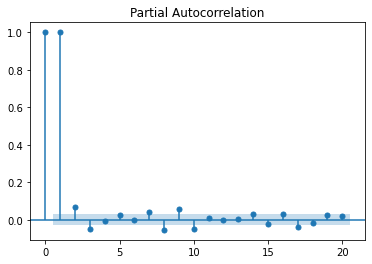

In [816]:
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_pacf


plot_pacf(stocks['Adj Close'], lags=20)
pyplot.show()

We can see that the PACF becomes almost silent after lag(1). This means that an AR model is best in our situation in comparison with MA model. See [PSU Stat510: PACF](https://online.stat.psu.edu/stat510/lesson/2/2.2)

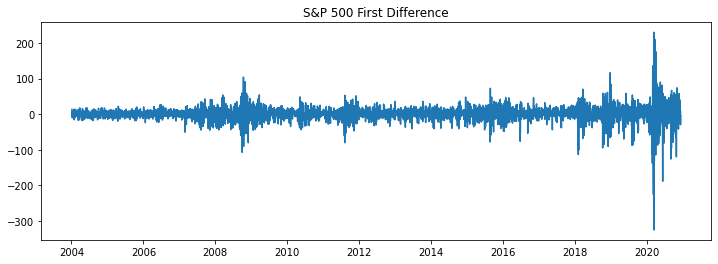

In [817]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(12, 4))
plt.plot((stocks['Adj Close']-stocks['Adj Close'].shift())[1:])
plt.title('S&P 500 First Difference')
plt.show()

In 2008, 2009 and in February/March 2020 which correspond to stock market crashes, we observe an exponential behaviour. To avoid that these periods overinfluence our models due to their high variance, we're going to apply the natural logarithm function to our values. 

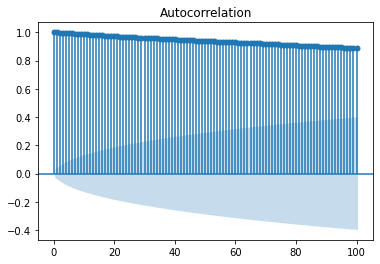

In [818]:
from pandas import read_csv
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

series = stocks['Adj Close']
plot_acf(series, lags=100)
plt.show()

The ACF is decreasing linearly with the number of lags. 

https://dspace.mit.edu/bitstream/handle/1721.1/55206/609415506-MIT.pdf?sequence=2&isAllowed=y

#### Seasonality

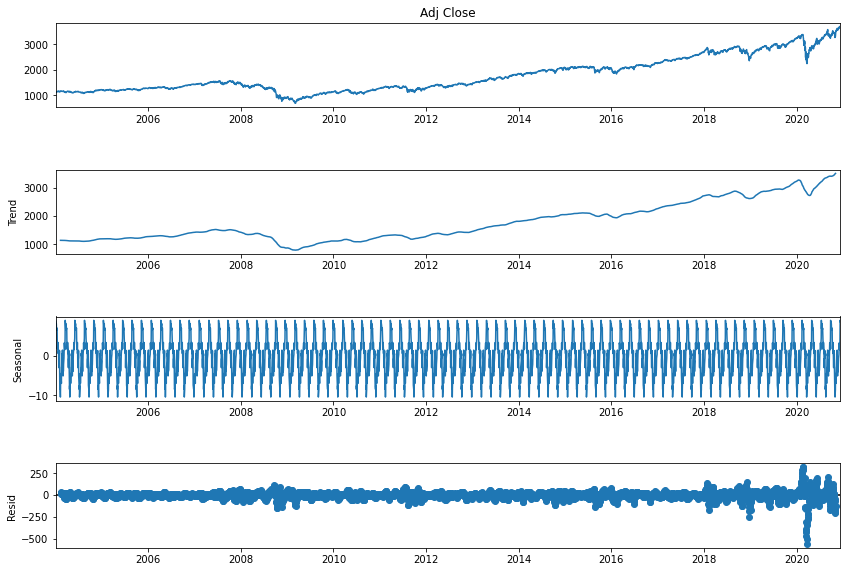

In [819]:
from statsmodels.tsa.seasonal import seasonal_decompose
sd = seasonal_decompose(stocks['Adj Close'], model='additive', period=52)  
#plt.figure(figsize=(12, 10))
fig = sd.plot()
fig.set_size_inches(13,9)
plt.show()

There doesn't seem to be any significant yearly or weekly seasonality. Let's check the monthly seasonality. 

In [820]:
stocks['m'] = stocks.index.month

<AxesSubplot:xlabel='m'>

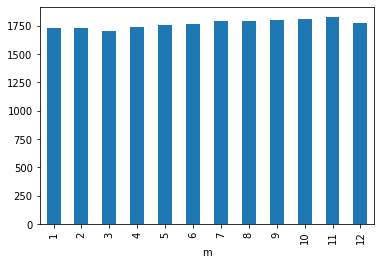

In [821]:
stocks.groupby('m')['Adj Close'].mean().plot.bar()

There is a weak monthly seasonality. 

# 0.4 Preprocessing

#### Applying logn

In [822]:
import math 
stocks['Log Adj Close'] = list(map(lambda x: math.log1p(x), stocks['Adj Close'].values))

<AxesSubplot:xlabel='Date'>

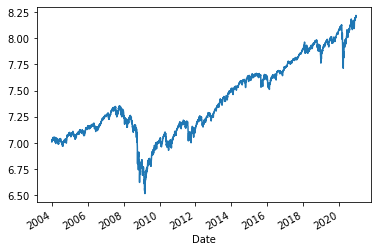

In [823]:
stocks['Log Adj Close'].plot()

<AxesSubplot:xlabel='Date'>

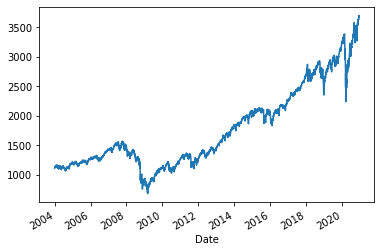

In [824]:
stocks['Adj Close'].plot()

#### Resampling

The closing stock price is generally considered as an accurate market signal. (See [Closing Price](https://www.investopedia.com/terms/c/closingprice.asp)). Thereafter we'll only consider the Adjusted Closing value of each trading week.

In [825]:
keep_last = lambda x: x.tail(1)

In [826]:
stocks_wfri = stocks.resample('W-FRI').apply(keep_last)
stocks_wfri.head()

,Open,High,Low,Close,Adj Close,Volume,m,Log Adj Close
Date,,,,,,,,
2004-01-02,1111.920044,1118.849976,1105.079956,1108.479980,1108.479980,1153200000,1,7.011647
2004-01-09,1131.920044,1131.920044,1120.900024,1121.859985,1121.859985,1720700000,1,7.023634
2004-01-16,1132.050049,1139.829956,1132.050049,1139.829956,1139.829956,1721100000,1,7.039511
2004-01-23,1143.939941,1150.310059,1136.849976,1141.550049,1141.550049,1561200000,1,7.041018
2004-01-30,1134.109985,1134.170044,1127.729980,1131.130005,1131.130005,1635000000,1,7.031856


The closing stock price is considered as an accurate market signal. (See [Closing Price](https://www.investopedia.com/terms/c/closingprice.asp)). Thereafter we're considering only the Adjusted Closing value of each trading week.

# Prediction

For the prediction part, we have to split our data in two parts, one for training and one for testing.  
We decided the testing data to start the 1st January 2020. 

In [827]:
training_period = stocks_wfri.index <= pd.Timestamp(2020, 1, 1)
testing_period = stocks_wfri.index > pd.Timestamp(2020, 1, 1)
train = stocks_wfri[training_period]['Log Adj Close']
test = stocks_wfri[testing_period]['Log Adj Close']

## Best AR Model

For this part, `pmdarima` is needed. It is equivalent to R's auto.arima functionality. 

Installation :  
`pip install pmdarima`

Fit ARIMA(0,1,0)x(0,0,0,1) [intercept=True]; AIC=-3938.597, BIC=-3929.144, Time=0.162 seconds
Fit ARIMA(0,1,1)x(0,0,0,1) [intercept=True]; AIC=-3940.338, BIC=-3926.160, Time=0.117 seconds
Fit ARIMA(0,1,2)x(0,0,0,1) [intercept=True]; AIC=-3939.424, BIC=-3920.519, Time=0.169 seconds
Fit ARIMA(0,1,3)x(0,0,0,1) [intercept=True]; AIC=-3944.113, BIC=-3920.481, Time=0.225 seconds


/Users/jeannechaverot/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


Fit ARIMA(0,1,4)x(0,0,0,1) [intercept=True]; AIC=-3942.325, BIC=-3913.968, Time=0.670 seconds
Fit ARIMA(0,1,5)x(0,0,0,1) [intercept=True]; AIC=-3941.859, BIC=-3908.775, Time=0.489 seconds
Fit ARIMA(1,1,0)x(0,0,0,1) [intercept=True]; AIC=-3940.631, BIC=-3926.452, Time=0.067 seconds


/Users/jeannechaverot/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Fit ARIMA(1,1,1)x(0,0,0,1) [intercept=True]; AIC=-3936.235, BIC=-3917.330, Time=0.530 seconds
Fit ARIMA(1,1,2)x(0,0,0,1) [intercept=True]; AIC=-3941.000, BIC=-3917.368, Time=0.782 seconds
Fit ARIMA(1,1,3)x(0,0,0,1) [intercept=True]; AIC=-3941.988, BIC=-3913.631, Time=0.698 seconds
Fit ARIMA(1,1,4)x(0,0,0,1) [intercept=True]; AIC=-3940.118, BIC=-3907.035, Time=0.289 seconds
Fit ARIMA(2,1,0)x(0,0,0,1) [intercept=True]; AIC=-3940.103, BIC=-3921.198, Time=0.143 seconds


/Users/jeannechaverot/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/jeannechaverot/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Fit ARIMA(2,1,1)x(0,0,0,1) [intercept=True]; AIC=-3937.924, BIC=-3914.293, Time=0.320 seconds
Fit ARIMA(2,1,2)x(0,0,0,1) [intercept=True]; AIC=-3937.673, BIC=-3909.316, Time=0.214 seconds


/Users/jeannechaverot/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


Fit ARIMA(2,1,3)x(0,0,0,1) [intercept=True]; AIC=-3942.075, BIC=-3908.992, Time=0.915 seconds
Fit ARIMA(3,1,0)x(0,0,0,1) [intercept=True]; AIC=-3943.587, BIC=-3919.956, Time=0.117 seconds
Fit ARIMA(3,1,1)x(0,0,0,1) [intercept=True]; AIC=-3941.671, BIC=-3913.313, Time=0.257 seconds
Fit ARIMA(3,1,2)x(0,0,0,1) [intercept=True]; AIC=-3941.421, BIC=-3908.337, Time=0.345 seconds
Fit ARIMA(4,1,0)x(0,0,0,1) [intercept=True]; AIC=-3942.048, BIC=-3913.690, Time=0.141 seconds
Fit ARIMA(4,1,1)x(0,0,0,1) [intercept=True]; AIC=-3940.002, BIC=-3906.918, Time=0.150 seconds
Fit ARIMA(5,1,0)x(0,0,0,1) [intercept=True]; AIC=-3940.826, BIC=-3907.742, Time=0.152 seconds
Total fit time: 6.967 seconds


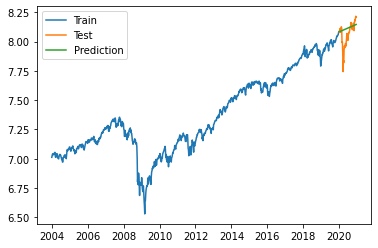

In [828]:
from pmdarima import auto_arima
arima = auto_arima(train, max_d=4, max_p=6, max_q=6, max_Q=2, trace=True, stepwise=False)
arima.fit(train)
predictions = arima.predict(n_periods=test.shape[0])
predictions = pd.DataFrame(data=predictions,index = test.index)

plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(predictions, label='Prediction')
plt.legend()
plt.show()

## Trends

To determine which trends are the best predictors, we're going to test them individually and observe in which extent they improve our out-of-sample predictions. 

In [829]:
df.index = pd.to_datetime(df.index)
df = df.resample('W-FRI').apply(keep_last)
df.head()

,mastercard,google,housing,pepsico,invest,hedge,bonds,revenues,finance,berkshire,...,opportunity,happy,health,mcdonalds,movie,return,comcast,medtronic,johnson,stocks
date,,,,,,,,,,,,,,,,,,,,,
2004-01-09,63,56,75,27,77,69,81,36,91,55,...,42,62,99,55,82,94,75,66,25,89
2004-01-16,68,55,90,33,63,69,81,29,93,28,...,42,64,99,56,79,91,74,44,26,97
2004-01-23,61,62,81,22,59,70,77,50,85,48,...,34,69,98,46,78,83,80,61,26,100
2004-01-30,50,57,78,1,65,65,72,88,97,31,...,100,60,98,62,77,87,72,40,25,93
2004-02-06,77,57,78,64,62,67,75,49,96,30,...,46,57,93,62,70,90,58,77,27,77


In [830]:
stocks_wfri = stocks_wfri.iloc[1:,:]
stocks_wfri.head()

,Open,High,Low,Close,Adj Close,Volume,m,Log Adj Close
Date,,,,,,,,
2004-01-09,1131.920044,1131.920044,1120.900024,1121.859985,1121.859985,1720700000,1,7.023634
2004-01-16,1132.050049,1139.829956,1132.050049,1139.829956,1139.829956,1721100000,1,7.039511
2004-01-23,1143.939941,1150.310059,1136.849976,1141.550049,1141.550049,1561200000,1,7.041018
2004-01-30,1134.109985,1134.170044,1127.729980,1131.130005,1131.130005,1635000000,1,7.031856
2004-02-06,1128.589966,1142.790039,1128.390015,1142.760010,1142.760010,1477600000,2,7.042076


In [831]:
data = pd.concat([df, stocks_wfri], axis=1)
data.head()

,mastercard,google,housing,pepsico,invest,hedge,bonds,revenues,finance,berkshire,...,johnson,stocks,Open,High,Low,Close,Adj Close,Volume,m,Log Adj Close
date,,,,,,,,,,,,,,,,,,,,,
2004-01-09,63,56,75,27,77,69,81,36,91,55,...,25,89,1131.920044,1131.920044,1120.900024,1121.859985,1121.859985,1720700000,1,7.023634
2004-01-16,68,55,90,33,63,69,81,29,93,28,...,26,97,1132.050049,1139.829956,1132.050049,1139.829956,1139.829956,1721100000,1,7.039511
2004-01-23,61,62,81,22,59,70,77,50,85,48,...,26,100,1143.939941,1150.310059,1136.849976,1141.550049,1141.550049,1561200000,1,7.041018
2004-01-30,50,57,78,1,65,65,72,88,97,31,...,25,93,1134.109985,1134.170044,1127.729980,1131.130005,1131.130005,1635000000,1,7.031856
2004-02-06,77,57,78,64,62,67,75,49,96,30,...,27,77,1128.589966,1142.790039,1128.390015,1142.760010,1142.760010,1477600000,2,7.042076


In [832]:
# look at value a month ago and a year ago (our time series is in weeks)

#df.iloc[0, df.columns.get_loc('COL_NAME')] = x


data['y(t-4)'] = np.nan
d_temp = list(data['Log Adj Close'].iloc[:-4])
data.iloc[4:,data.columns.get_loc('y(t-4)')] = d_temp
#pd.DataFrame(data['Log Adj Close']).T.shift(periods=4, axis=1).T

data['y(t-52)'] = np.nan
d_temp2 = list(data['Log Adj Close'].iloc[:-52])
data.iloc[52:, data.columns.get_loc('y(t-52)')] = d_temp2
#pd.DataFrame(data['Log Adj Close']).T.shift(periods=52, axis=1).T
#data = data.iloc[12:,:]

In [833]:
data = data.iloc[52:,:]

In [834]:
df_X = pd.concat([data.iloc[:,:-10], data.iloc[:,-2:]], axis=1)

In [835]:
df_X.columns

Index(['mastercard', 'google', 'housing', 'pepsico', 'invest', 'hedge',
       'bonds', 'revenues', 'finance', 'berkshire', 'consume', 'marriage',
       'home depot', 'environment', 'economy', 'short sell', 'leverage',
       'facebook', 'united health', 'amazon', 'merck', 'nyse', 'risk',
       'nasdaq', 'paypal', 'golf', 'pfizer', 'portfolio', 'food', 'cancer',
       'alphabet', 'procter and gamble', 'apple', 'netflix', 'abbott labs',
       'economics', 'success', 'credit', 'society', 'profit', 'intel', 'water',
       'fond', 'money', 'visa', 'rich', 'oracle', 'j p morgan', 'hold',
       'greed', 'spdr', 'investment', 'debt', 'present', 'loss', 'house',
       'gain', 'financial markets', 'employment', 'gross', 'consumption',
       'microsoft', 'crisis', 'inflation', 'adobe', 'headlines', 'at&t',
       'nvidia', 'transaction', 'buy', 'verizon communications', 'gains',
       'oil', 'war', 'cisco', 'unemployment', 'opportunity', 'happy', 'health',
       'mcdonalds', 'movie', '

In [836]:
X = df_X.values
y = data['Log Adj Close']

In [837]:
def predict(X, y, window):
    """
    This function is used to make the predictions. The parameters help set up the details of the model to be used.
    model: either takes value window or accumulate. If window, it means we use the previous 17 data point from the
    one we want to predict to create the model. If accumulate, we take all data points preceding the one we want
    to predict.
    recession: If false it means we are working on the whole data set. If true we are strinctly working on the days
    corresponding to the recession.
    """
    
    
    k = window
    y_tests = []
    y_hats = []
        
    #we take at least 5 training points 
    # points in the training set up until the kth data point
     
    for i in np.arange(5, k, 1):

        X_train = X[:i,:]
        X_test = X[i,:]

        y_train = y[:i]
        y_test = y[i]

        reg = LinearRegression()
        reg.fit(X_train, y_train)

        #X_test.reshape(1,X.shape[1])
        y_hat = reg.predict([X_test])
        y_tests.append(y_test)
        y_hats.append(y_hat)
            
        
    # now we do the second loop where we only use a window of k elements to train
        
    i = 0
        
    while i+k<X.shape[0]:

        X_train = X[i:i+k,:]
        X_test = X[i+k,:]
        y_train = y[i:i+k]
        y_test = y[i+k]

        reg = LinearRegression()
        reg.fit(X_train, y_train)

        y_hat = reg.predict([X_test])

        y_tests.append(y_test)
        y_hats.append(y_hat)

        i+=1
    y_hats = [el[0] for el in y_hats]
    return y_tests, y_hats
    

def plot_fig(y_test,y_test2, y_hat,y_hat_no_trends):
    """
    Function to plot the predictions for the model with and without trends versus real data
    y_tests: real value
    y_tests: real value from data points during recession
    y_hats: predicted values
    y_hats_trends: predicted values using trends in model
    y_hats_rec: predicted values from data points during recession
    y_hats_trends_rec: predicted values from data points during recession using trends in model
    model: specify which model we use: 17 days window training, or using all previous days
    
    
    """
    fig, ax = plt.subplots(figsize=(19,10))

    ax.plot(data.index[-len(y_test):], y_test, linestyle='solid', label='Actual')
    ax.plot(data.index[-len(y_test):], y_hat, linestyle='dashed', label='Trends')
    ax.plot(data.index[-len(y_test):], y_hat_no_trends, linestyle='solid', label='No trends')
    ax.legend(['Stocks', 'Trends predictions', 'No trends predictions'])
    ax.set_title('S&P500 predictions with and without Google Trends')
    ax.set_xlabel("Index")
    ax.set_ylabel("log(stocks)")

    # this if statement helps adjust the box around the text in the plot
    #ax.axhline(y=6, xmin=0, xmax=0.43, color='grey')
    #ax.axvline(x=pd.to_datetime('2008-01-01'), ymin=0, ymax=6.75, color='grey')
    # improvement between not using trends and using trends
    
    mae_base = sklearn.metrics.mean_absolute_error(y_test2, y_hat_no_trends)*100
    mae_trends = sklearn.metrics.mean_absolute_error(y_test, y_hat)*100
    pct = (mae_base-mae_trends)/max(mae_base, mae_trends)*100
    print('base', mae_base)
    print('trends', mae_trends)
    # improvement between not using trends and using trends during recession only
    

    textstr = '\n'.join((
        'MAE improvement',
        'Overall = {:.2f} %'.format(pct)))

    start = pd.to_datetime('2007-12-01')
    end = pd.to_datetime('2009-06-01')

    ax.text(0.05, 0.05, textstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='bottom')
    


### Optimize Windows and number of features for model including trends

In [838]:
from tqdm.notebook import tqdm
import time
start_time = time.time()

windows = np.arange(7, 30)
nb_features = np.arange(5, X.shape[1]+1)

grid = np.ndarray((len(windows), len(nb_features)))

for i, w in enumerate(windows):
    print('Optimizing for window of size ', w)
    for j, k in enumerate(nb_features):

        fs = SelectKBest(score_func=f_regression, k=k)
        fs.fit(X, y)
        X_new = fs.transform(X)
        
        y_test, y_hat = predict(X_new, y, w)
        
        mae = sklearn.metrics.mean_absolute_error(y_test,y_hat)*100
        grid[i, j] = mae
print("--- %s seconds ---" % (time.time() - start_time))
    

Optimizing for window of size  7
Optimizing for window of size  8
Optimizing for window of size  9
Optimizing for window of size  10
Optimizing for window of size  11
Optimizing for window of size  12
Optimizing for window of size  13
Optimizing for window of size  14
Optimizing for window of size  15
Optimizing for window of size  16
Optimizing for window of size  17
Optimizing for window of size  18
Optimizing for window of size  19
Optimizing for window of size  20
Optimizing for window of size  21
Optimizing for window of size  22
Optimizing for window of size  23
Optimizing for window of size  24
Optimizing for window of size  25
Optimizing for window of size  26
Optimizing for window of size  27
Optimizing for window of size  28
Optimizing for window of size  29
--- 1024.2022383213043 seconds ---


In [839]:
window_idx, features_idx = np.where(grid == grid.min())

'The loss when using trends is minimized and returns {:.3f} for a window of size {} taking into account {} features'.format(np.min(grid), windows[window_idx[0]], nb_features[features_idx[0]])

'The loss when using trends is minimized and returns 2.357 for a window of size 8 taking into account 40 features'

In [840]:

fs = SelectKBest(score_func=f_regression, k=40)
fs.fit(X, y)
X_new = fs.transform(X)
        
y_test1, y_hat1 = predict(X_new, y, 8)
        
mae = sklearn.metrics.mean_absolute_error(y_test1,y_hat1)*100

mae

2.3568104263990546

In [841]:
mask = fs.get_support() #list of booleans
new_features = [] # The list of your K best features
feature_names = list(df_X.columns.values)


for bool, feature in zip(mask, feature_names):
    if bool:
        new_features.append(feature)
        print(feature)

mastercard
hedge
finance
berkshire
home depot
short sell
leverage
facebook
amazon
risk
nasdaq
paypal
procter and gamble
intel
water
fond
money
rich
oracle
j p morgan
loss
house
gain
gross
microsoft
crisis
inflation
adobe
headlines
at&t
nvidia
oil
war
unemployment
opportunity
health
mcdonalds
return
y(t-4)
y(t-52)


### Optimize Windows for model that doesn't include trends

In [842]:
X_no_trends = df_X.iloc[:,-2:].values

start_time = time.time()

windows = np.arange(7, 30)

grid = []
for i, w in enumerate(windows):
    print('Computing loss for window of size ', w)
    y_test, y_hat = predict(X_no_trends, y, w)
        
    mae = sklearn.metrics.mean_absolute_error(y_test,y_hat)*100
    grid.append(mae)
print("--- %s seconds ---" % (time.time() - start_time))


Computing loss for window of size  7
Computing loss for window of size  8
Computing loss for window of size  9
Computing loss for window of size  10
Computing loss for window of size  11
Computing loss for window of size  12
Computing loss for window of size  13
Computing loss for window of size  14
Computing loss for window of size  15
Computing loss for window of size  16
Computing loss for window of size  17
Computing loss for window of size  18
Computing loss for window of size  19
Computing loss for window of size  20
Computing loss for window of size  21
Computing loss for window of size  22
Computing loss for window of size  23
Computing loss for window of size  24
Computing loss for window of size  25
Computing loss for window of size  26
Computing loss for window of size  27
Computing loss for window of size  28
Computing loss for window of size  29
--- 13.945919275283813 seconds ---


In [843]:
'The loss without trends is minimized and returns {:.3f} for a window of size {}'.format(np.min(grid), windows[np.argmin(grid)])




'The loss without trends is minimized and returns 2.815 for a window of size 8'

In [844]:

y_test2, y_hat2 = predict(X_no_trends, y, 8)
        
mae_no_trends = sklearn.metrics.mean_absolute_error(y_test2,y_hat2)*100

mae_no_trends

2.81549424920047

base 2.81549424920047
trends 2.3568104263990546


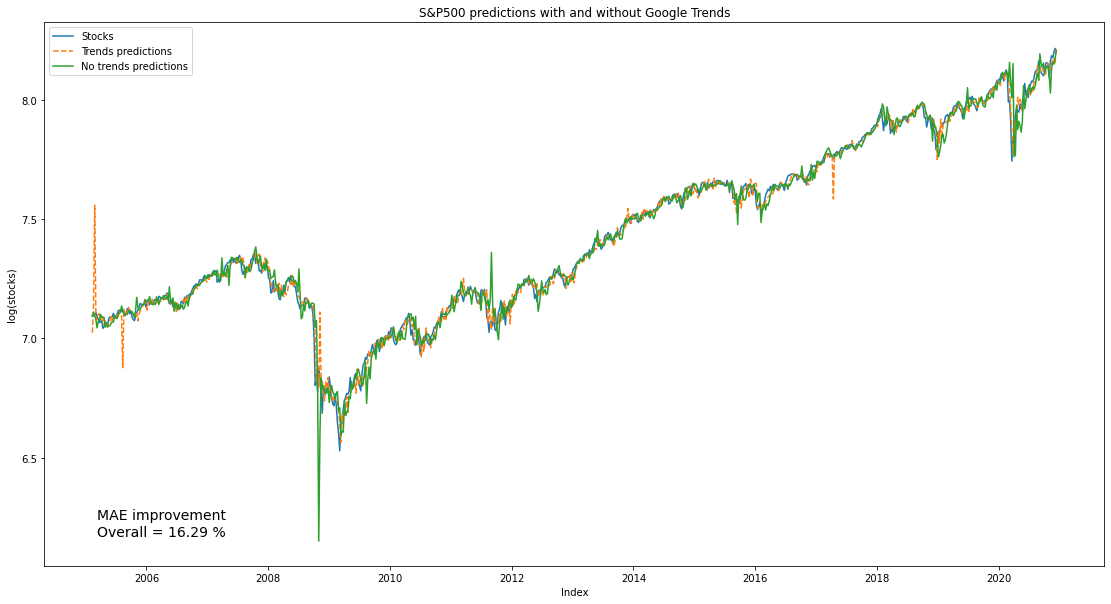

In [845]:
plot_fig(y_test1,y_test2, y_hat1,y_hat2)

### Turning points analyses

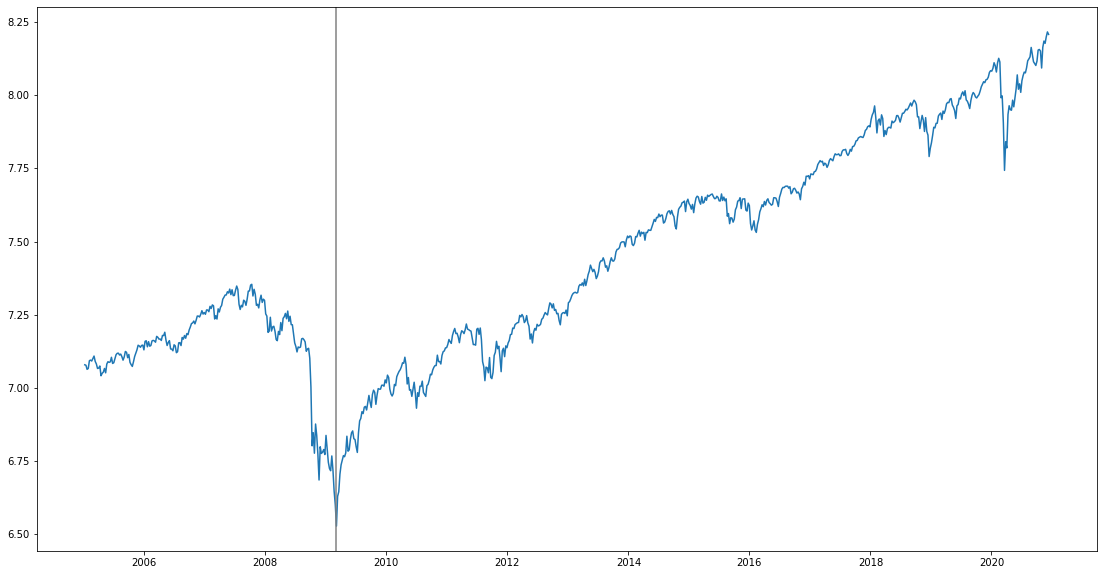

In [846]:
fig, ax = plt.subplots(figsize=(19,10))

ax.plot(data.index, data['Log Adj Close'], linestyle='solid', label='Actual')
ax.axvline(x=pd.to_datetime('2009-03-01'), ymin=0, ymax=6.75, color='grey')

From here on, we know that the features we want to keep are
- pfizer
- j p morgan
- spdr
- y(t-4)
- y(t-52)

In [847]:
tp1_start = '2008-08-15'
tp1_end = '2008-11-01'

tp2_start = '2010-04-20'
tp2_end = '2010-07-20'

tp3_start = '2011-07-15'
tp3_end = '2011-10-15'

tp4_start = '2015-08-01'
tp4_end = '2015-10-01'

tp5_start = '2016-01-01'
tp5_end = '2016-03-01'

tp6_start = '2018-11-20'
tp6_end = '2019-01-01'

tp7_start = '2020-02-15'
tp7_end = '2020-04-01'



### Turning point 1

Function to predict on turning points

In [848]:
#we predict each value and then add real data to train test

def pred_tp(X_train, y_train, X_test, y_test, trends=True):
    """This function does the prediction when we use the Google trends as features"""
    y_preds = []
    acc = X_train.shape[0]
    for i in range(X_test.shape[0]):
        acc += 1
        reg = LinearRegression()
        reg.fit(X_train, y_train)
        #print(X_test[i])
        y_preds.append(reg.predict(X_test[i].reshape(1,-1))[0])
        #print(X_train)
        X_train = np.vstack((X_train, X_test[i]))
        #X_train = np.append(X_train,X_test[i]).reshape(acc, 5)
        y_train = np.append(y_train,y_test[i])
    return y_preds

def pred_no_trends(X_train, y_train, X_test, y_test):
    """This function does the prediction when we do not use the Google trends as features"""
    y_preds = []
    acc = X_train.shape[0]

    for i in range(X_test.shape[0]):
        reg = LinearRegression()
        reg.fit(X_train.reshape(acc,2), y_train)
        acc += 1

        #print(X_test[i])
        y_preds.append(reg.predict(X_test[i].reshape(1,-1))[0])
        #print(X_train)
        X_train = np.vstack((X_train, X_test[i]))
        #X_train = np.append(X_train,X_test[i]).reshape(acc, 1)
        y_train = np.append(y_train,y_test[i])
        
    return y_preds


In [849]:
tps = [
    [tp1_start, tp1_end],
    [tp2_start, tp2_end],
    [tp3_start, tp3_end],
    [tp4_start, tp4_end],
    [tp5_start, tp5_end],
    [tp6_start, tp6_end],
    [tp7_start, tp7_end]
]

In [850]:
maes_tp_trends = []
maes_tp_notrends = []

#create our X matrices
X_temp_trends = df_X[new_features].values
X_temp_notrends = df_X.iloc[:,-2:].values



for tp in tps:
    
    #compute mae for each turning point with trends
    X_train = X_temp[df_X.index < tp[0]]
    X_test = X_temp[(df_X.index>= tp[0]) & (df_X.index <= tp[1])]

    y_train = y[df_X.index < tp[0]]
    y_test = y[(df_X.index>= tp[0]) & (df_X.index <= tp[1])]

    y_preds = pred_tp(X_train, y_train, X_test, y_test)

    maes_tp_trends.append(sklearn.metrics.mean_absolute_error(y_test, y_preds))

    # ----#

    #compute mae for each turning point without trends

    X_train = X_temp_notrends[df_X.index < tp[0]]
    X_test = X_temp_notrends[(df_X.index>= tp[0]) & (df_X.index <= tp[1])]

    y_train = y[df_X.index < tp[0]]
    y_test = y[(df_X.index>= tp[0]) & (df_X.index <= tp[1])]

    y_preds = pred_no_trends(X_train, y_train, X_test, y_test)

    maes_tp_notrends.append(sklearn.metrics.mean_absolute_error(y_test, y_preds))

In [851]:
pcts = [str((maes_tp_notrends[i]-maes_tp_trends[i])/max(maes_tp_notrends[i], maes_tp_trends[i])*100)[:5]+'%' for i in range(len(maes_tp_trends))]


In [852]:
df = pd.DataFrame({
    'Start': [tp[0] for tp in tps],
    'End': [tp[1] for tp in tps],
    'MAE base': maes_tp_notrends,
    'MAE trends': maes_tp_trends,
    '1-ratio': pcts
})

In [853]:
df

,Start,End,MAE base,MAE trends,1-ratio
0,2008-08-15,2008-11-01,0.106701,0.106428,0.256%
1,2010-04-20,2010-07-20,0.057385,0.057168,0.377%
2,2011-07-15,2011-10-15,0.059607,0.059766,-0.26%
3,2015-08-01,2015-10-01,0.034641,0.034628,0.035%
4,2016-01-01,2016-03-01,0.031243,0.031161,0.262%
5,2018-11-20,2019-01-01,0.054435,0.054464,-0.05%
6,2020-02-15,2020-04-01,0.161318,0.161104,0.132%
